In [1]:
from torch_geometric.datasets import Flickr
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os

%load_ext autoreload
%autoreload 2


In [2]:
dataset = Flickr('data/Flickr')
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[22313, 500], edge_index=[2, 58636], y=[22313], train_mask=[22313], val_mask=[22313], test_mask=[22313])

In [3]:
G = to_networkx(test_subgraph).to_undirected()

In [4]:
G

In [5]:
def get_nbhd_weights(G, node, k, geom=True):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if geom:
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'] - 1)  # Weight =
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [6]:
# exp_path = 'experiments/09-09-2022_23-16-17_Flickr'
# exp_path = 'experiments/12-09-2022_19-02-33_Flickr'
exp_path = 'experiments/15-09-2022_00-22-32_Flickr_SHADOW'

# exp_path = 'experiments/15-09-2022_00-22-32_Flickr_SHADOW'
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
# preds = preds[lcc_nodes]
# test_x = test_subgraph.x[lcc_nodes].numpy()
# test_y = test_subgraph.y[lcc_nodes].numpy()
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

22313
22313
22313


In [22]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.26648471942681085

In [69]:
preds

,0,1,2,3,4,5,6
0,0.071690,0.045592,0.105652,0.094716,0.298284,0.029033,0.355033
1,0.042319,0.184556,0.047098,0.044298,0.352138,0.021946,0.307645
2,0.044562,0.238716,0.041662,0.029441,0.170928,0.030377,0.444314
3,0.061409,0.068094,0.083683,0.056268,0.291246,0.038177,0.401123
4,0.068712,0.098561,0.088218,0.052387,0.174833,0.038006,0.479283
...,...,...,...,...,...,...,...
22308,0.066278,0.109719,0.042311,0.016233,0.032854,0.057960,0.674645
22309,0.056655,0.077465,0.060677,0.070828,0.454762,0.024900,0.254712
22310,0.086850,0.038315,0.095082,0.067431,0.156068,0.048272,0.507982
22311,0.106789,0.026490,0.099024,0.041613,0.051038,0.061223,0.613824


In [70]:
G.number_of_nodes()

22313

In [71]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 50
quantiles_nb = []
def calibrate_nbhd(node):
    nbs = get_nbhd_weights(G, node, k=2, geom=False)
    two_hop = nbs[nbs.distance == 2]
    nb_ids = two_hop['node_id'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values), alpha)
        return {node: quantile[0]}
quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)

/tmp/ipykernel_241812/2252916567.py:13: TqdmWarning: Iterable length 22313 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)


  0%|          | 0/22313 [00:00<?, ?it/s]

In [72]:
nz = [p for p in quantiles_nb if p is not None]
res = {}
for p in nz:
    res.update(p)
nbhd_quantiles = pd.Series(res, name='quantile')
nbhd_quantiles
lcc_nodes = nbhd_quantiles.index.values
sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')

In [73]:
len(lcc_nodes)

4955

In [74]:
n_trials = 100
n_calib = 1000

In [75]:
nb_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_calib, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    nb_stats.append(evaluate_predictions(sets_nb[pred_nodes].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values)
                                         ))
    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values)))


  0%|          | 0/100 [00:00<?, ?it/s]

,coverage,set_size,cc_set_size
count,100.000000,100.000000,100.000000
mean,0.909370,4.096830,4.115421
std,0.008166,0.025142,0.025088
min,0.889000,4.043000,4.059801
25%,0.903000,4.080750,4.099421
50%,0.909500,4.095500,4.117390
75%,0.915000,4.116250,4.132712
max,0.927000,4.177000,4.184466


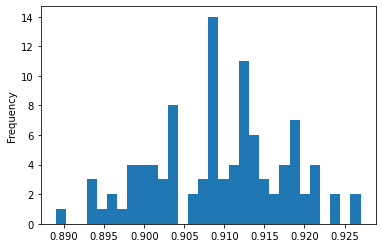

In [76]:
nb_df = pd.DataFrame(nb_stats, columns=['coverage', 'set_size', 'cc_set_size'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size
count,100.000000,100.000000,100.000000
mean,0.909960,4.245220,4.251968
std,0.008289,0.023533,0.022678
min,0.883000,4.187000,4.198901
25%,0.904000,4.230000,4.234703
50%,0.910000,4.243500,4.251507
75%,0.915000,4.262250,4.268315
max,0.935000,4.311000,4.311563


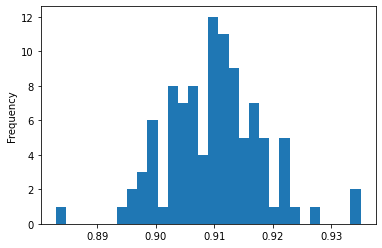

In [77]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()